In [608]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

In [609]:
# default seaborn kwargs
w, h = (15, 8)
sns.set(rc = {'figure.figsize':(w, h)})
_sns = dict(height=h, aspect=w/h)

## One-sample, two-sided

$ H_0: \mu = a $

$ H_1: \mu \ne a $

In [645]:
mu = 10         # mean of x
sigma = 0.5       # std of x
N = int(5e2)         # number of samples
alpha = 1e-2    # desired test significance

x = np.random.normal(size=(N,))*sigma + mu
a = np.random.normal()/np.sqrt(N) + mu

print(f'Testing H0: mu = {round(a, 4)}')

Testing H0: mu = 10.0094


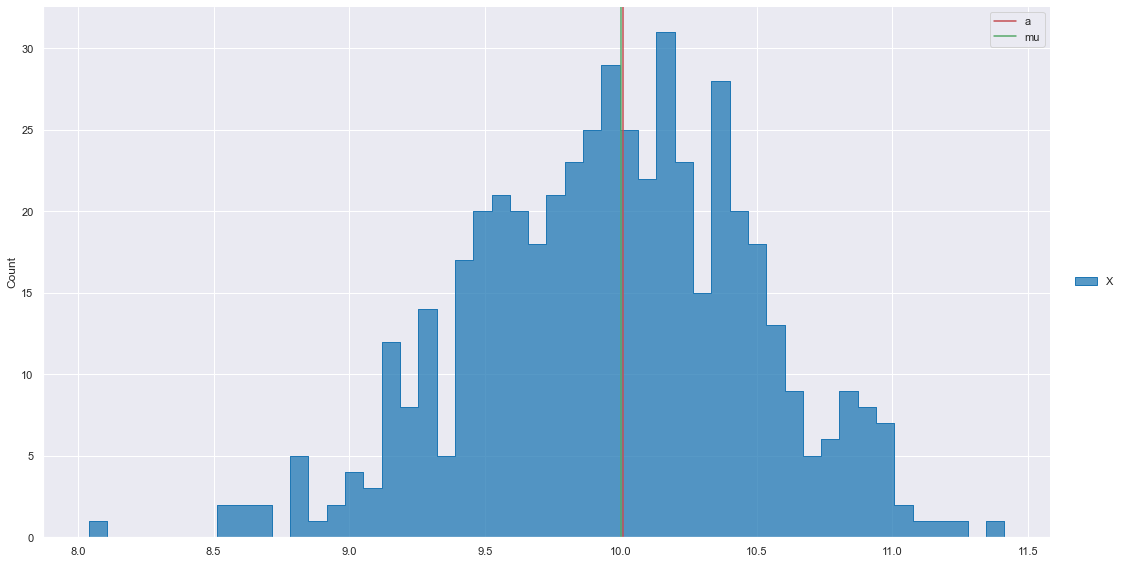

In [646]:
df = pd.DataFrame({"X" : x}, index=pd.Series(range(len(x))))
sns.displot(df, element='step', bins=50, **_sns)
plt.axvline(a, color="r", label="a")
plt.axvline(mu, color="g", label="mu")
plt.legend()

We use a Z-test when we know the variance and want to test the mean of a normally distributed variable.  

Under $H_0$, our sample mean follows a distribution of $ N(a, \sigma^2/N) $

We will reject $ H_0 $ if $ | \bar{x} - a | > \gamma $

We do not have a specific alternative hypothesis for this test since $ H_1: \mu \ne a $ still allows $ \mu $ to take many values.

The significance of this test $ \alpha = P($ reject $ H_0 | H_0) = P(\bar{x} < a - \gamma | H_0) + P(\bar{x} > a + \gamma | H_0) $

Let's compute the significance as a function of $\gamma$.


In [647]:
rv = scipy.stats.norm(loc=a, scale=np.sqrt(sigma**2/N))
significance_fn = lambda gamma: 2*rv.cdf(a-gamma)

gammas = np.linspace(1/N, 100/N, 100)
significances = np.vectorize(significance_fn)(gammas)

Text(0.5, 1.0, 'Significance vs Gamma')

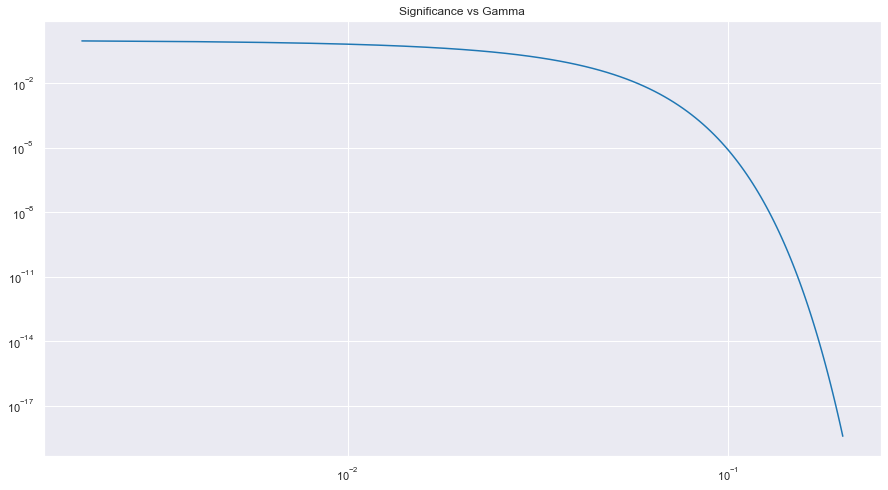

In [648]:
sns.lineplot(x=gammas, y=significances)
plt.yscale('log'), plt.xscale('log')
plt.title('Significance vs Gamma')

In [649]:
gamma = a - rv.ppf(alpha/2)

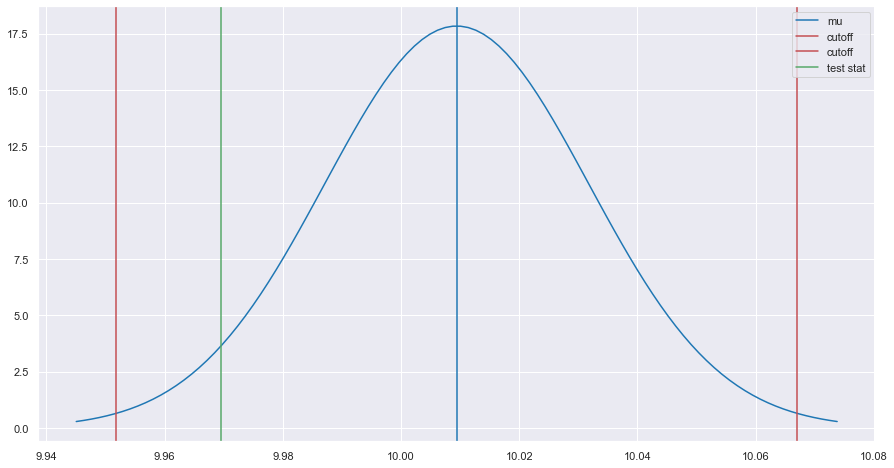

In [650]:
_x = np.linspace(rv.ppf(1/N), rv.ppf(1-(1/N)), 100)
p_x = rv.pdf(_x)
sns.lineplot(x=_x, y=p_x)
plt.axvline(a, label='mu')
plt.axvline(a+gamma, color='r', label='cutoff')
plt.axvline(a-gamma, color='r', label='cutoff')
plt.axvline(x.mean(), color='g', label='test stat')
plt.legend()

In [651]:
delta = abs(x.mean() - a)
if delta > gamma:
    print('Reject H0')
else:
    print('Fail to reject H0')

Fail to reject H0


In [652]:
pvalue = rv.cdf(a - delta)*2
pvalue

0.07441281869797423

In [618]:
# as N increases, it is easier to reject the null hypothesis; with more samples, we can detect smaller deviations from the hypothesized mean
max_N = 1e6
base = 2.3
n_per = 100
delta_sigmas = ( 2, 1, 0.5, 0.25, 0.01 )

_end = np.log(max_N)/np.log(base)
Ns = base**np.arange(2, _end)

# a list of (N, H0); do we reject H0 more as N increases?
simulations = list()
for ds in delta_sigmas:
    for N in Ns.astype('int64'):
        for _ in range(n_per):

            x = np.random.normal(size=(N,))*sigma + mu
            a = mu + np.random.normal()*ds

            # test statistic distribution
            rv = scipy.stats.norm(loc=a, scale=np.sqrt(sigma**2/N))

            # choose gamma based on desired significance
            gamma = a - rv.ppf(alpha/2)

            # decide whether to reject H0
            delta = abs(x.mean() - a)
            simulations.append((ds, N, int(delta > gamma)))

Text(0.5, 0, 'N samples')

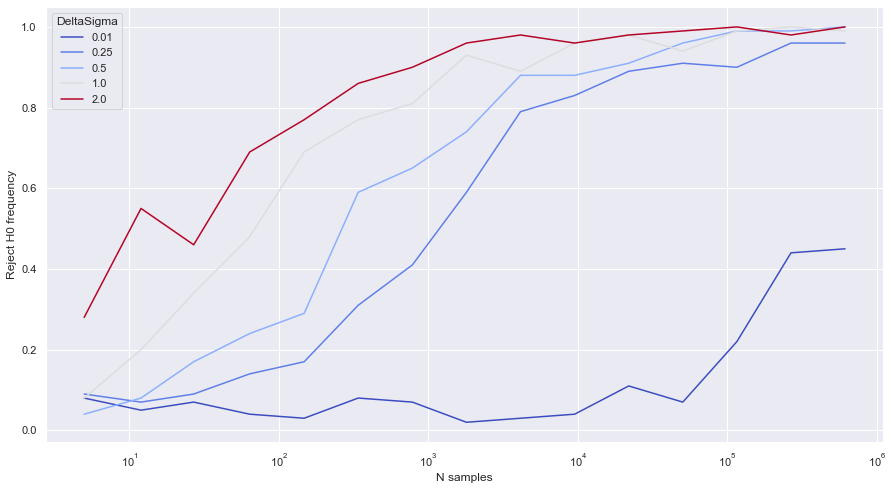

In [619]:
df = pd.DataFrame(simulations, columns=['DeltaSigma', 'N', 'RejectH0'])
results = df.groupby(by=['DeltaSigma', 'N'], as_index=False).mean()
sns.set_palette("tab10")
sns.lineplot(
    data=results, 
    x='N', 
    y='RejectH0', 
    hue='DeltaSigma',
    palette=sns.color_palette('coolwarm', as_cmap = True)
)
plt.xscale('log')
plt.ylabel('Reject H0 frequency')
plt.xlabel('N samples')

<br>

## One-sample, one-sided

$ H_0: \mu \geq a $

$ H_1: \mu \lt a $

In [445]:
mu = 10         # mean of x
sigma = 3       # std of x
N = 100         # number of samples
alpha = 1e-3    # desired test significance

x = np.random.normal(size=(N,))*sigma + mu
a = np.random.normal()*sigma/10 + mu

print(f'Testing H0: mu >= {round(a, 2)}')

Testing H0: mu >= 10.18


Again, we assume that the variance of $x$ is known. 

We reject the null hypothesis if $ \bar{x} < \gamma $ where $ \gamma $ is chosen such that the significance of the test, $ \alpha = P($ reject $H_0|H_0 )$, is sufficiently small.  

We can compute $ \alpha = P(\bar{x} < \gamma | H_0) = P(\bar{x} < \gamma | \mu = a) $.  We use $ \mu = a $ for the significance computation as it maximizes $ \alpha $ under $ H_0 $.

In [446]:
# a model for the distribution of the sample mean, the test statistic, under H0
rv = scipy.stats.norm(loc=a, scale=np.sqrt(sigma**2/N))

# the significance of the test is the probability that we reject H0 given that H0 is true
significance_fn = lambda gamma: rv.cdf(gamma)

# test many possible values for gamma
gammas = np.linspace(rv.ppf(0.0001), rv.ppf(.9999), 100)
significances = np.vectorize(significance_fn)(gammas)

Text(0.5, 1.0, 'Significance vs Gamma')

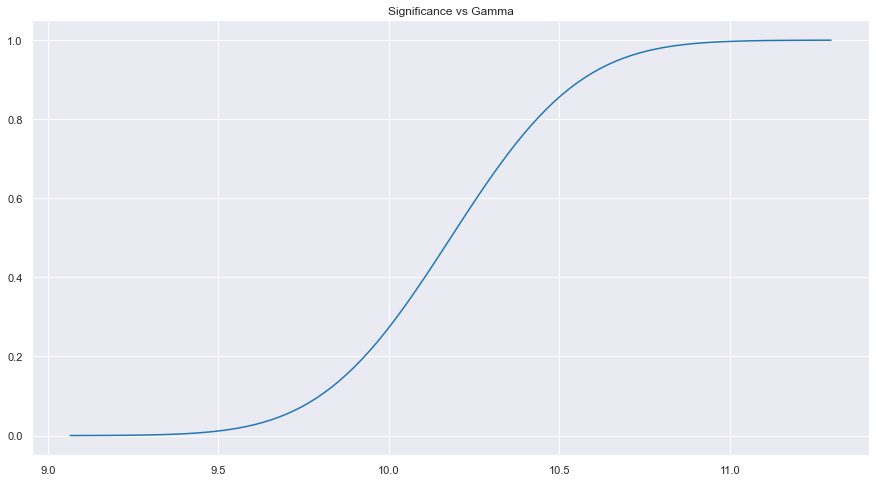

In [447]:
# indeed , this is the CDF of the test statistic
sns.lineplot(x=gammas, y=significances)
# plt.yscale('log')
plt.title('Significance vs Gamma')

In [448]:
# find largest gamma that yields a significance less than alpha
_arg_sort = np.argsort(significances)[::-1]
gammas, significances = gammas[_arg_sort], significances[_arg_sort]
gamma = gammas[np.argwhere(significances < alpha)[0]].item()
significance_fn(gamma)

0.0009105273417656699

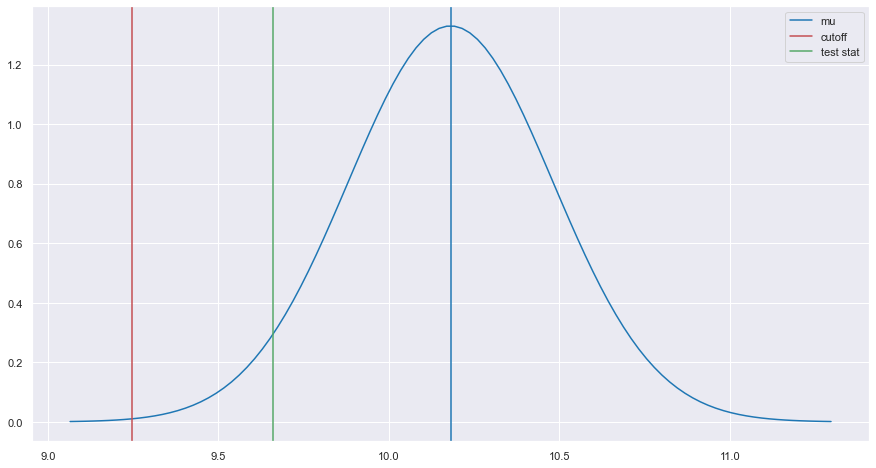

In [449]:
# if the test statistic is less than the cutoff, we reject H0
_x = np.linspace(rv.ppf(0.0001), rv.ppf(0.9999), 100)
p_x = rv.pdf(_x)
sns.lineplot(x=_x, y=p_x)
plt.axvline(a, label='mu')
plt.axvline(gamma, color='r', label='cutoff')
plt.axvline(x.mean(), color='g', label='test stat')
plt.legend()

In [450]:
if x.mean() < gamma:
    print('Reject H0')
else:
    print('Fail to reject H0')

Fail to reject H0


<br>

## Two-sample, two-sided

$ H_0: \mu_a = \mu_b $

$ H_1: \mu_a \ne \mu_b $

In [607]:
mu_a, sigma_a, N_a = 10.1, 2.7, 100       # dist of x_a
mu_b, sigma_b, N_b = 10.8, 1.5, 400       # dist of x_b
alpha = 1e-2    # desired test significance

x_a = np.random.normal(size=(N_a))*sigma_a + mu_a
x_b = np.random.normal(size=(N_b))*sigma_b + mu_b

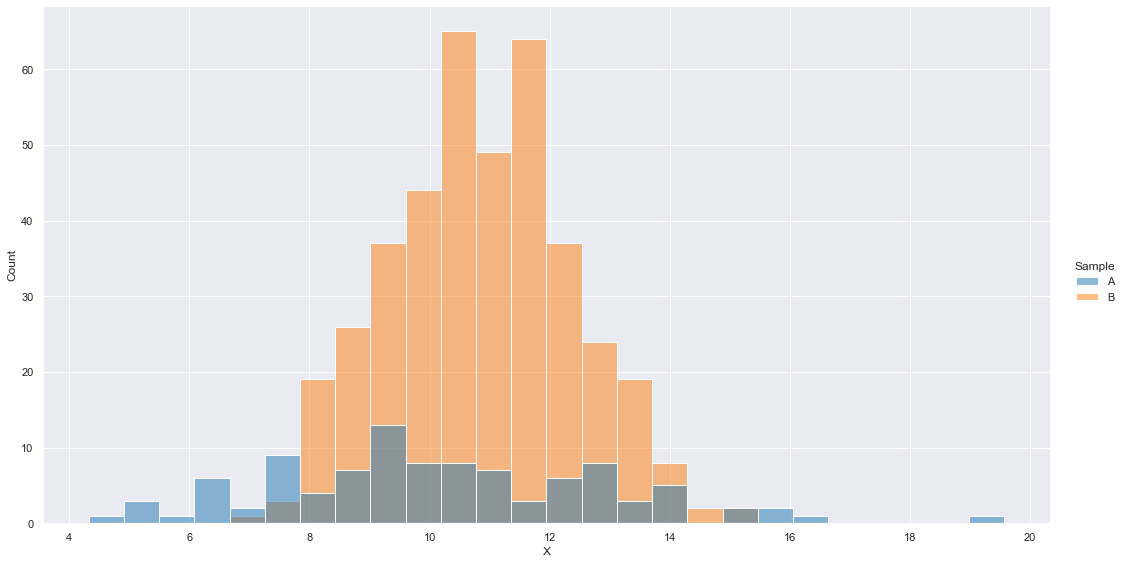

In [599]:
df = pd.DataFrame([('A', _xa) for _xa in x_a] + [('B', _xb) for _xb in x_b], columns=['Sample', 'X'])
sns.displot(df, x='X', hue='Sample', **_sns)

We will conduct the test by choosing $ H_0 $ if $ |\bar{x}_a - \bar{x}_b | > \gamma $.

Under $ H_0 $, $ x_a \sim N(\mu, \sigma_a^2), x_b \sim N(\mu, \sigma_b^2) \implies \bar{x}_a \sim N(\mu_a, \sigma_a^2/N_a), \bar{x}_b \sim N(\mu_b, \sigma_b^2/N_b)$

Therefore, let $ t(x) = \bar{x}_a - \bar{x}_b $ where $ t(x) \sim N(\mu_a - \mu_b, \frac{\sigma^2_a}{N_a} + \frac{\sigma^2_b}{N_b}) $

Reject $H_0$ if $ |t(x) > \gamma | $

To find significance, find $ \alpha = P(|t(x)| > \gamma | H_0) $.

Equivalently, in the spirit of the Z-test, let $ z(x) = \frac{t(x) - (\mu_a - \mu_b)}{\sqrt{\sigma_a^2/N_a + \sigma_b^2/N_b}} $

In [600]:
# let's model the distribution of t(x) under the null hypothesis => mu_t = 0
mu_t = 0
var_t = (sigma_a**2/N_a) + (sigma_b**2/N_b)
rvtx = scipy.stats.norm(loc=mu_t, scale=np.sqrt(var_t))
assert np.isclose(rvtx.mean(), mu_t) and np.isclose(rvtx.var(), var_t)


In [601]:
# for any gamma, alpha will be 2*CDF(gamma), since the distribution of t(x) is normal
significance_fn = lambda gamma: 2*rvtx.cdf(gamma)
significance_fn(-1*2*np.sqrt(var_t))

0.04550026389635839

In [602]:
# equivalently, we can normalize t(x) and compute the z score
tx = x_a.mean() - x_b.mean()
ztx = (tx - mu_t)/(np.sqrt(var_t))

In [603]:
# since z follows a standard normal distribution, we can compute alpha from a standard normal distribution
significance_fn = lambda gamma: 2*scipy.stats.norm().cdf(-1*gamma)
significance_fn(1.96)

# for a two-tailed test, divide alpha by two, since it will be split between the two tails
gamma = -1*scipy.stats.norm().ppf(alpha/2)
np.isclose(significance_fn(gamma), alpha)

True

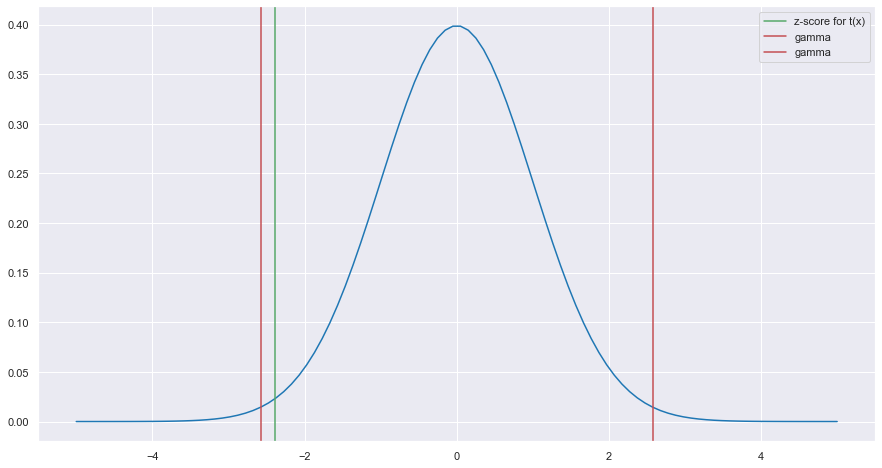

In [604]:
_x = np.linspace(-5, 5, 100)
sns.lineplot(x=_x, y=scipy.stats.norm().pdf(_x))
plt.axvline(ztx, label='z-score for t(x)', color='g')
plt.axvline(-gamma, label='gamma', color='r')
plt.axvline(gamma, label='gamma', color='r')
plt.legend()

In [605]:
if -gamma < ztx < gamma:
    print('Failed to reject the null hypothesis')
else:
    print('Reject the null hypothesis')

Failed to reject the null hypothesis


In [606]:
pvalue = 2*scipy.stats.norm().cdf(-1*abs(ztx))
pvalue

0.017082797506641514